In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from scipy.signal import ShortTimeFFT
from sklearn.preprocessing import StandardScaler
from stockwell import st
import time

#### Create Mixed Signals

In [2]:
def sph_to_cart(theta_deg, phi_deg, mag=1.0):
    th = np.deg2rad(theta_deg)
    ph = np.deg2rad(phi_deg)
    return np.array([
        mag*np.sin(th)*np.cos(ph),
        mag*np.sin(th)*np.sin(ph),
        mag*np.cos(th)
    ], float)

def hat(v):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized")
    return v / n

"Create Mixed Signals"
fs=40.0
Tsec=120.0
seed=1

"""Two triaxial sensors, shared ambient + 2 deterministic disturbances."""
rng = np.random.default_rng(seed)
t = np.arange(0, Tsec, 1.0/fs)
N = t.size

# Ambient Field Signal
B0 = np.column_stack([
    0.4*np.sin(2*np.pi*0.04*t) + 0.6*np.cos(2*np.pi*0.1*t),
    0.4*np.cos(2*np.pi*0.03*t + 0.6) + 0.6*np.sin(2*np.pi*0.1*t),
    0.3*np.sin(2*np.pi*0.025*t + 1.1) + 0.7*np.cos(2*np.pi*0.05*t),
]) + np.array([3, -2, 1])[None, :]

# Interference Signals
S_A = np.sin(2*np.pi*(0.12*t + 0.001*t**2))
S_B = 0.6*np.sin(2*np.pi*(0.26*t - 0.0008*t**2) + 0.4) + signal.square(2*np.pi*1*t)*0.4
S_C = signal.sawtooth(2*np.pi*0.5*t)
S_D = 0.5*np.sin(2*np.pi*5*t + 0.2) + 0.5*np.sin(2*np.pi*12*t + 1.0)

H1A = sph_to_cart(50, 240, 20); H2A = sph_to_cart(52, 132, 1)
H1B = sph_to_cart(180,  50, 10); H2B = sph_to_cart(44, 100, 1)
H1C = sph_to_cart(120, 300, 15); H2C = sph_to_cart(130, -210, 0.5)
H1D = sph_to_cart(300, 150, 5); H2D = sph_to_cart(310, -60, 0.2)

h1_true = np.array([hat(H1A), hat(H1B), hat(H1C), hat(H1D)])
h2_true = np.array([hat(H2A), hat(H2B), hat(H2C), hat(H2D)])
k_true = np.array([
    np.linalg.norm(H2A)/np.linalg.norm(H1A),
    np.linalg.norm(H2B)/np.linalg.norm(H1B),
    np.linalg.norm(H2C)/np.linalg.norm(H1C),
])

# Create Mixed Signals
b1 = np.outer(S_A, H1A) + np.outer(S_B, H1B) + np.outer(S_C, H1C) + np.outer(S_D, H1D)
b2 = np.outer(S_A, H2A) + np.outer(S_B, H2B) + np.outer(S_C, H2C) + np.outer(S_D, H2D)
B = np.zeros((2, 3, N))
B[0] = (B0 + b1).T
B[1] = (B0 + b2).T

#### Take Stockwell Transform


In [17]:
fmin = 0  # Hz
fmax = 20  # Hz
df = 1./(t[-1]-t[0])  # sampling step in frequency domain (Hz)
fmin_samples = int(fmin/df)
fmax_samples = int(fmax/df)

S = np.array([[st.st(B[j, i, :], fmin_samples, fmax_samples, gamma=20) for i in range(3)] for j in range(B.shape[0])])
print(S.shape)

(2, 3, 2400, 4800)


In [4]:
from scipy.signal.windows import hann
window = hann(256)
SFT = ShortTimeFFT(win = window, hop = 100, fs = fs)
S = SFT.stft(B, axis=2)  # Shape (2, 3, F, T)

#### Filter Signals
1. Identify Single Source Points
2. Remove low magnitude noise
3. Remove Ambient Field Signal
4. Align phase for clustering

In [7]:
"Filter SSPs and magnitude"
def is_SSP(Sf, similarity=0.98):
    """
    Sf: complex STFT, shape (n_sensors, 3, F, T)
    similarity: threshold on |cos(Re, Im)| for SSP detection
    Returns: mask of shape (F, T), True where bin is SSP.
    """
    n_sensors, n_axis, F, T = Sf.shape

    # Flatten sensors and axes into a single "channel" dimension
    X = Sf.reshape(n_sensors * n_axis, F, T)  # (M, F, T), M = n_sensors * 3

    A = np.real(X)
    B = np.imag(X)

    # Dot product and norms along channel axis
    dot = np.sum(A * B, axis=0)                       # (F, T)
    normA = np.linalg.norm(A, axis=0)                 # (F, T)
    normB = np.linalg.norm(B, axis=0)                 # (F, T)

    # Cosine similarity, safe divide
    cos_sim = np.divide(
        dot,
        normA * normB,
        out=np.zeros_like(dot),
        where=(normA * normB) != 0
    )

    # SSP if real and imag are (anti-)parallel
    return np.abs(cos_sim) >= similarity

def magnitude_filter(Sf, percentile):
    """
    Sf: (n_sensors, 3, F, T)
    Returns: mask (F, T) where multi-channel magnitude is above threshold.
    """
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    m = np.linalg.norm(X, axis=0)  # (F, T)
    threshold = np.percentile(m, percentile)
    return m >= threshold

def ambient_filter(Sf, similarity=0.98):
    """
    Equal-gain ambient filter using triad magnitudes per sensor.
    """
    n_sensors, n_axis, F, T = Sf.shape
    mags = np.linalg.norm(Sf, axis=1)  # (n_sensors, F, T)

    ones = np.ones_like(mags)
    dot = np.sum(mags * ones, axis=0)
    normA = np.linalg.norm(mags, axis=0)
    normB = np.linalg.norm(ones, axis=0)

    cos_sim = np.divide(dot,
                        normA * normB,
                        out=np.zeros_like(dot),
                        where=(normA * normB) != 0)

    return cos_sim >= similarity

SSP_mask = is_SSP(S, similarity=0.9)
MAG_mask = magnitude_filter(S, percentile=90.0)
ambient_mask = ambient_filter(S, similarity=0.8)
mask = SSP_mask & MAG_mask & (~ambient_mask)


In [8]:
SSP_data = S[:, :, mask]  # Shape (2, 3, n_bins)
print(f"Number of SSP bins after masking: {SSP_data.shape[2]}")

Number of SSP bins after masking: 260


#### Cluster SSP data to find gain and directions

In [9]:
def remove_global_phase_two_sensor(v1, v2):
    """
    Remove a single global phase for clustering.

    v1, v2 : complex (3,)
    Returns:
        v1p, v2p : phase-aligned complex (3,)
    """
    # Stack components from both sensors, pick the strongest as phase reference
    stacked = np.concatenate([v1, v2])
    idx = np.argmax(np.abs(stacked))
    if np.abs(stacked[idx]) == 0:
        return v1, v2  # degenerate, let caller handle

    phi = np.angle(stacked[idx])
    factor = np.exp(-1j * phi)
    return v1 * factor, v2 * factor

def cluster_gain_and_dir(SSP_data, min_cluster_size=10, n_keep=3):
    """
    Estimate disturbance source directions and gains from SSP bins.

    Parameters
    ----------
    SSP_data : np.ndarray
        Shape (2, 3, n_bins), complex STFT values at selected SSP bins.
    min_cluster_size : int
        Minimum cluster size for HDBSCAN.
    n_keep : int
        Number of largest clusters (sources) to return.

    Returns
    -------
    h1_dirs : (m, 3)
        Unit disturbance directions at sensor 1.
    h2_dirs : (m, 3)
        Unit disturbance directions at sensor 2.
    k_gain : (m,)
        Gain per source, |H2| / |H1|.
    """
    B1 = SSP_data[0].T  # (n_bins, 3)
    B2 = SSP_data[1].T  # (n_bins, 3)

    dirs1 = []
    dirs2 = []
    gains = []

    for v1, v2 in zip(B1, B2):
        # Magnitudes for gain
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 == 0 or n2 == 0:
            continue

        # One global phase for both sensors
        v1p, v2p = remove_global_phase_two_sensor(v1, v2)

        a1 = np.real(v1p)
        a2 = np.real(v2p)

        if np.linalg.norm(a1) == 0 or np.linalg.norm(a2) == 0:
            continue

        h1 = hat(a1)
        h2 = hat(a2)

        # Enforce a consistent global sign convention:
        # flip BOTH if needed, never individually.
        # Example: require h1's z >= 0 (any deterministic rule is fine).
        if h1[2] < 0:
            h1 = -h1
            h2 = -h2

        g = n2 / n1
        if not np.isfinite(g):
            continue

        dirs1.append(h1)
        dirs2.append(h2)
        gains.append(g)

    if not dirs1:
        raise ValueError("No valid SSP-derived features found.")

    dirs1 = np.asarray(dirs1)
    dirs2 = np.asarray(dirs2)
    gains = np.asarray(gains)

    # Features for clustering: [h1, h2, log(g)]; standardized for clustering
    feats = np.column_stack([dirs1, dirs2, np.log(gains)])
    X = StandardScaler().fit_transform(feats)

    labels = HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(X)

    # Keep largest n_keep non-noise clusters
    unique = [lab for lab in np.unique(labels) if lab >= 0]
    if not unique:
        raise ValueError("HDBSCAN found no clusters.")

    sizes = [(lab, np.sum(labels == lab)) for lab in unique]
    sizes.sort(key=lambda x: x[1], reverse=True)
    keep = [lab for lab, _ in sizes[:n_keep]]

    h1_dirs = []
    h2_dirs = []
    k_gain = []

    for lab in keep:
        idx = labels == lab
        if np.sum(idx) == 0:
            continue

        h1_mean = hat(dirs1[idx].mean(axis=0))
        h2_mean = hat(dirs2[idx].mean(axis=0))
        g_med = np.median(gains[idx])

        # Apply the same sign convention at cluster level
        if h1_mean[2] < 0:
            h1_mean = -h1_mean
            h2_mean = -h2_mean

        h1_dirs.append(h1_mean)
        h2_dirs.append(h2_mean)
        k_gain.append(g_med)

    return np.vstack(h1_dirs), np.vstack(h2_dirs), np.asarray(k_gain)

h1_dirs, h2_dirs, k_gain = cluster_gain_and_dir(SSP_data, n_keep=4)
print("Estimated Directions and Gains:"
      f"\n h1_dirs:\n{h1_dirs}"
      f"\n h2_dirs:\n{h2_dirs}"
      f"\n k_gain:\n{k_gain}")

Estimated Directions and Gains:
 h1_dirs:
[[-0.43346593  0.75367431  0.49404688]
 [ 0.74456067 -0.39516144  0.53803052]
 [ 0.86475164 -0.24626032  0.43767619]
 [ 0.39305176 -0.72742605  0.56246037]]
 h2_dirs:
[[ 0.66292782 -0.37325449  0.64900523]
 [-0.34417319  0.64719147  0.68021175]
 [-0.15715997  0.61431085  0.77325476]
 [-0.10120869 -0.52816923 -0.84308604]]
 k_gain:
[0.03361306 0.04348027 0.11340754 0.11135824]


In [14]:
"Google"
import numpy as np
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
from scipy.ndimage import grey_dilation
import warnings
from scipy import signal

# Note: You must have numpy, scipy, sklearn, hdbscan, and scipy installed
# pip install numpy scipy scikit-learn hdbscan

## 1. Core Vector & Frame Utilities

def sph_to_cart(theta_deg, phi_deg, mag=1.0):
    """Converts spherical coordinates (degrees) to Cartesian."""
    th = np.deg2rad(theta_deg)
    ph = np.deg2rad(phi_deg)
    return np.array([
        mag*np.sin(th)*np.cos(ph),
        mag*np.sin(th)*np.sin(ph),
        mag*np.cos(th)
    ], float)

def hat(v):
    """Returns the unit vector in the direction of v."""
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0:
        # Handle zero vector case gracefully for this application
        return np.zeros_like(v)
    return v / n

def make_skew_frame(dirs):
    """
    Build 3x3 skewed frame:
    first len(dirs) columns are exactly the given unit directions,
    remaining column(s) just complete a basis.
    """
    dirs = [hat(v) for v in dirs]
    m = len(dirs)

    if m == 0:
        return np.eye(3)

    if m == 1:
        v1 = dirs[0]
        # Pick a candidate vector not (anti-)parallel to v1
        cand = np.array([1.0, 0.0, 0.0]) if abs(v1[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
        u2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, u2))
        return np.column_stack([v1, u2, u3])

    if m == 2:
        v1, v2 = dirs
        # If nearly colinear, tweak v2 to ensure a valid basis
        if np.linalg.norm(np.cross(v1, v2)) < 1e-6:
            cand = np.array([1.0, 0.0, 0.0]) if abs(v1[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
            v2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, v2))
        return np.column_stack([v1, v2, u3])

    # m >= 3: just take first three directions
    # This is key: dafgrad_clean is implicitly limited to 3 disturbers.
    v1, v2, v3 = dirs[:3]
    return np.column_stack([v1, v2, v3])

## 2. DAFgrad Cleaning Algorithm

def dafgrad_clean(B, h1_dirs, h2_dirs, k_gain):
    """
    Dual-sensor DAFgrad in skewed frames.
    This function projects out the disturbance subspace defined by
    the disturbance directions and gains.

    Parameters
    ----------
    B : np.ndarray
        Signal data, shape (2, 3, N). N can be time samples or T-F bins.
    h1_dirs : np.ndarray
        (m, 3) unit disturbance directions at sensor 1.
    h2_dirs : np.ndarray
        (m, 3) unit disturbance directions at sensor 2.
    k_gain : np.ndarray
        (m,) gains, |H2_k| / |H1_k| for each source k.

    Returns
    -------
    B_clean : np.ndarray
        Cleaned signals, shape (2, 3, N).
    """
    B = np.asarray(B, dtype=B.dtype) # Keep complex if complex
    if B.shape[0] != 2 or B.shape[1] != 3:
        raise ValueError("B must have shape (2, 3, N)")

    h1_dirs = np.asarray(h1_dirs, float)
    h2_dirs = np.asarray(h2_dirs, float)
    k_gain = np.asarray(k_gain, float)

    if h1_dirs.ndim == 1: h1_dirs = h1_dirs[np.newaxis, :]
    if h2_dirs.ndim == 1: h2_dirs = h2_dirs[np.newaxis, :]
    if k_gain.ndim == 0: k_gain = k_gain[np.newaxis]

    if h1_dirs.shape != h2_dirs.shape:
        raise ValueError("h1_dirs and h2_dirs must have same shape")

    m = h1_dirs.shape[0]
    if m == 0:
        # No sources to clean, return original signal
        return B
    if k_gain.shape[0] != m:
        raise ValueError(f"k_gain length ({k_gain.shape[0]}) must match number of sources ({m})")

    # Unit direction vectors
    h1 = np.array([hat(v) for v in h1_dirs])
    h2 = np.array([hat(v) for v in h2_dirs])

    # Reconstruct disturbance vectors up to scale:
    H1 = h1
    H2 = k_gain[:, np.newaxis] * h2 # (m, 3)

    # Difference disturbance vectors
    HDelta = H1 - H2
    hD = np.array([hat(v) for v in HDelta]) # (m, 3)

    denom = np.linalg.norm(HDelta, axis=1) # (m,)
    if np.any(denom < 1e-12):
        # This can happen if h1=h2 and k_gain=1 (e.g., ambient noise)
        # We can't clean this, so just return
        warnings.warn("Degenerate H1 - H2 for some source. Skipping cleaning for this bin.")
        return B
    
    alpha1 = np.linalg.norm(H1, axis=1) / denom # (m,)
    alpha2 = np.linalg.norm(H2, axis=1) / denom # (m,)

    T1_inv = make_skew_frame(list(h1)) # (3, 3)
    T2_inv = make_skew_frame(list(h2)) # (3, 3)
    TD_inv = make_skew_frame(list(hD)) # (3, 3)

    try:
        T1 = np.linalg.inv(T1_inv)
        T2 = np.linalg.inv(T2_inv)
        TD = np.linalg.inv(TD_inv)
    except np.linalg.LinAlgError:
        warnings.warn("Singular skew frame. Skipping cleaning for this bin.")
        return B

    B1 = B[0].T
    B2 = B[1].T
    BD = B1 - B2

    B1_p = (T1 @ B1.T).T
    B2_p = (T2 @ B2.T).T
    BD_p = (TD @ BD.T).T

    B1_p_clean = B1_p.copy()
    B2_p_clean = B2_p.copy()
    
    # Ensure m is capped at 3, as make_skew_frame only uses 3 vectors
    m_capped = min(m, 3) 
    
    for k in range(m_capped):
        B1_p_clean[:, k] -= alpha1[k] * BD_p[:, k]
        B2_p_clean[:, k] -= alpha2[k] * BD_p[:, k]

    B1_c = (T1_inv @ B1_p_clean.T).T
    B2_c = (T2_inv @ B2_p_clean.T).T

    B_clean = np.empty_like(B)
    B_clean[0] = B1_c.T
    B_clean[1] = B2_c.T
    return B_clean

## 3. SSP Identification (T-F Masking)

def is_SSP(Sf, similarity=0.98):
    """Identifies Single Source Points (SSPs)."""
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    A = np.real(X)
    B = np.imag(X)
    dot = np.sum(A * B, axis=0)
    normA = np.linalg.norm(A, axis=0)
    normB = np.linalg.norm(B, axis=0)
    norm_prod = normA * normB
    cos_sim = np.divide(dot, norm_prod, out=np.zeros_like(dot, dtype=float), where=norm_prod != 0)
    return np.abs(cos_sim) >= similarity

def magnitude_filter(Sf, percentile):
    """Magnitude filter."""
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    m = np.linalg.norm(X, axis=0) # (F, T)
    threshold = np.percentile(m, percentile)
    return m >= threshold

def ambient_filter(Sf, similarity=0.98):
    """Ambient noise filter."""
    n_sensors, n_axis, F, T = Sf.shape
    mags = np.linalg.norm(Sf, axis=1) # (n_sensors, F, T)
    ones = np.ones_like(mags)
    dot = np.sum(mags * ones, axis=0)
    normA = np.linalg.norm(mags, axis=0)
    normB = np.linalg.norm(ones, axis=0)
    norm_prod = normA * normB
    cos_sim = np.divide(dot, norm_prod, out=np.zeros_like(dot, dtype=float), where=norm_prod != 0)
    return cos_sim >= similarity

## 4. Disturbance Subspace Estimation (Clustering)

def remove_global_phase_two_sensor(v1, v2):
    """Remove a single global phase from two vectors for clustering."""
    stacked = np.concatenate([v1, v2])
    idx = np.argmax(np.abs(stacked))
    ref_val = stacked[idx]
    if np.abs(ref_val) == 0:
        return v1, v2
    phi = np.angle(ref_val)
    factor = np.exp(-1j * phi)
    return v1 * factor, v2 * factor

def cluster_gain_and_dir_all(SSP_data, min_cluster_size=10):
    """
    Estimate disturbance source directions and gains for ALL non-noise
    clusters found by HDBSCAN.

    Parameters
    ----------
    SSP_data : np.ndarray
        Shape (2, 3, n_bins), complex STFT values at selected SSP bins.
    min_cluster_size : int
        Minimum cluster size for HDBSCAN.

    Returns
    -------
    disturbance_params : list of dicts
        A list where each element corresponds to a cluster (cluster_id).
        Each dict is: {'h1': (3,), 'h2': (3,), 'kg': float}
    ssp_labels : np.ndarray
        (n_bins,) array of cluster labels for each SSP.
    """
    B1 = SSP_data[0].T # (n_bins, 3)
    B2 = SSP_data[1].T # (n_bins, 3)

    dirs1 = []
    dirs2 = []
    gains = []
    valid_indices = [] # Keep track of which original bins are valid

    for i, (v1, v2) in enumerate(zip(B1, B2)):
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 < 1e-12 or n2 < 1e-12:
            continue

        v1p, v2p = remove_global_phase_two_sensor(v1, v2)
        a1 = np.real(v1p)
        a2 = np.real(v2p)

        if np.linalg.norm(a1) < 1e-12 or np.linalg.norm(a2) < 1e-12:
            continue

        h1 = hat(a1)
        h2 = hat(a2)

        if h1[2] < 0:
            h1 = -h1
            h2 = -h2

        g = n2 / n1
        if not np.isfinite(g):
            continue

        dirs1.append(h1)
        dirs2.append(h2)
        gains.append(g)
        valid_indices.append(i) # This is an index into B1/B2

    if not dirs1:
        raise ValueError("No valid SSP-derived features found for clustering.")

    dirs1 = np.asarray(dirs1)
    dirs2 = np.asarray(dirs2)
    gains = np.asarray(gains)
    valid_indices = np.asarray(valid_indices)

    feats = np.column_stack([dirs1, dirs2, np.log(gains)])
    X = StandardScaler().fit_transform(feats)

    clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
    labels_valid = clusterer.fit_predict(X)

    # Map labels back to the original n_bins size
    # All invalid or un-clustered (noise) bins get label -1
    ssp_labels = np.full(B1.shape[0], -1, dtype=int)
    ssp_labels[valid_indices[labels_valid >= 0]] = labels_valid[labels_valid >= 0]
    
    unique_labels = [lab for lab in np.unique(labels_valid) if lab >= 0]
    if not unique_labels:
        raise ValueError("HDBSCAN found no clusters.")

    # Create a parameter list, indexed by cluster_id
    max_label = np.max(unique_labels)
    disturbance_params = [None] * (max_label + 1)
    
    print(f"HDBSCAN found {len(unique_labels)} clusters.")

    for lab in unique_labels:
        idx = (labels_valid == lab)
        if not np.any(idx):
            continue

        h1_mean = hat(dirs1[idx].mean(axis=0))
        h2_mean = hat(dirs2[idx].mean(axis=0))
        g_med = np.median(gains[idx])

        if h1_mean[2] < 0:
            h1_mean = -h1_mean
            h2_mean = -h2_mean

        params = {'h1': h1_mean, 'h2': h2_mean, 'kg': g_med}
        disturbance_params[lab] = params
        
    return disturbance_params, ssp_labels


## 5. NEW: Per-Channel Subspace Pursuit Pipeline

def clean_tf_data_per_channel(Sf,
                               ssp_similarity=0.95,
                               mag_percentile=90.0,
                               ambient_similarity=0.8,
                               min_cluster_size=20,
                               dilation_size=(3, 3)):
    """
    Full pipeline to clean time-frequency data on a PER-CHANNEL basis.
    Identifies all disturbers, maps them to T-F bins, and cleans
    each frequency channel using only its active disturbers.

    Parameters
    ----------
    Sf : np.ndarray
        Complex STFT data, shape (2, 3, F, T).
    ssp_similarity : float
        Threshold for is_SSP filter.
    mag_percentile : float
        Threshold for magnitude_filter.
    ambient_similarity : float
        Threshold for ambient_filter.
    min_cluster_size : int
        HDBSCAN min_cluster_size.
    dilation_size : tuple
        (freq_bins, time_bins) for smearing cluster labels.

    Returns
    -------
    Sf_clean : np.ndarray
        Cleaned complex STFT data, shape (2, 3, F, T).
    disturbance_map : np.ndarray
        (F, T) map of which cluster ID is active in each bin.
    """
    print("Starting PER-CHANNEL T-F data cleaning pipeline...")
    n_sensors, n_axis, F, T = Sf.shape
    if n_sensors != 2 or n_axis != 3:
        raise ValueError("Input Sf must have shape (2, 3, F, T)")

    # 1. Identify SSPs (Subspace Identification)
    print("Finding SSPs...")
    SSP_mask = is_SSP(Sf, similarity=ssp_similarity)
    MAG_mask = magnitude_filter(Sf, percentile=mag_percentile)
    ambient_mask = ambient_filter(Sf, similarity=ambient_similarity)
    mask = SSP_mask & MAG_mask & (~ambient_mask)
    
    if not np.any(mask):
        raise ValueError("No SSP bins found. Try relaxing filter thresholds.")
    print(f"Found {np.sum(mask)} SSP bins.")
    SSP_data = Sf[:, :, mask] # Shape (2, 3, n_bins)

    # 2. Estimate ALL Disturbance Subspaces (Clustering)
    print(f"Clustering SSPs to find ALL disturbance sources...")
    try:
        # disturbance_params is a list, indexed by cluster_id
        # ssp_labels is (n_bins,)
        disturbance_params, ssp_labels = cluster_gain_and_dir_all(
            SSP_data,
            min_cluster_size=min_cluster_size
        )
    except ValueError as e:
        print(f"Clustering failed: {e}")
        print("Returning original (uncleaned) data.")
        return Sf, None

    # 3. Build T-F Disturbance Map
    print("Building T-F disturbance map...")
    # Create a map, -1 = noise/no cluster
    disturbance_map = np.full((F, T), -1, dtype=int)
    
    # Place cluster labels onto the T-F grid at SSP locations
    disturbance_map[mask] = ssp_labels
    
    # 4. Dilate Map to propagate labels to non-SSP neighbors
    print("Propagating cluster labels to neighboring bins...")
    # This "smears" the cluster IDs. A bin gets the *max* cluster ID
    # in its neighborhood. This is fine, as -1 is lowest.
    structure = np.ones(dilation_size)
    dilated_map = grey_dilation(disturbance_map, footprint=structure)
    
    # 5. Build Per-Frequency Disturber Set
    # Find all disturbers active in each frequency row
    per_freq_clusters = []
    for f in range(F):
        active_ids_in_row = set(dilated_map[f, :]) - {-1}
        per_freq_clusters.append(active_ids_in_row)
        
    print(f"Found active disturbers in {sum(1 for s in per_freq_clusters if s)} of {F} freq channels.")

    # 6. Apply Per-Channel Cleaning (Subspace Pursuit)
    print("Applying per-channel cleaning...")
    Sf_clean = Sf.copy()
    
    for f in range(F):
        active_ids = per_freq_clusters[f]
        if not active_ids:
            continue # No disturbers for this frequency, skip
            
        # Get data slice for this frequency: (2, 3, T)
        Sf_slice = Sf[:, :, f, :]
        
        # Assemble disturbance parameters for *this* frequency
        try:
            h1_active = np.vstack([disturbance_params[cid]['h1'] for cid in active_ids])
            h2_active = np.vstack([disturbance_params[cid]['h2'] for cid in active_ids])
            kg_active = np.array([disturbance_params[cid]['kg'] for cid in active_ids])
        except (IndexError, TypeError):
            # This can happen if a cluster ID is in the map but not in params (shouldn't, but safety)
            warnings.warn(f"Error assembling params for freq {f}. Skipping.")
            continue
            
        # Clean the (2, 3, T) slice
        # dafgrad_clean is hard-coded to handle m <= 3 disturbers
        # via make_skew_frame
        if h1_active.shape[0] > 3:
            warnings.warn(f"Freq {f} has > 3 disturbers ({h1_active.shape[0]}). Using first 3.")
            
        Sf_clean_slice = dafgrad_clean(Sf_slice, h1_active, h2_active, kg_active)
        
        # Put the cleaned slice back
        Sf_clean[:, :, f, :] = Sf_clean_slice

    print("Per-channel cleaning complete.")
    return Sf_clean, dilated_map


## 6. Example Usage

if __name__ == "__main__":
    # --- Create some dummy data ---
    "Create Mixed Signals"
    fs=40.0
    Tsec=120.0
    seed=1

    """Two triaxial sensors, shared ambient + 2 deterministic disturbances."""
    rng = np.random.default_rng(seed)
    t = np.arange(0, Tsec, 1.0/fs)
    N = t.size

    # Ambient Field Signal
    B0 = np.column_stack([
        0.4*np.sin(2*np.pi*0.04*t) + 0.6*np.cos(2*np.pi*0.1*t),
        0.4*np.cos(2*np.pi*0.03*t + 0.6) + 0.6*np.sin(2*np.pi*0.1*t),
        0.3*np.sin(2*np.pi*0.025*t + 1.1) + 0.7*np.cos(2*np.pi*0.05*t),
    ]) + np.array([3, -2, 1])[None, :]

    # Interference Signals
    S_A = np.sin(2*np.pi*(0.12*t + 0.001*t**2))
    S_B = 0.6*np.sin(2*np.pi*(0.26*t - 0.0008*t**2) + 0.4) + signal.square(2*np.pi*1*t)*0.4
    S_C = signal.sawtooth(2*np.pi*0.5*t)

    H1A = sph_to_cart(50, 240, 20); H2A = sph_to_cart(52, 132, 1)
    H1B = sph_to_cart(180,  50, 10); H2B = sph_to_cart(44, 100, 1)
    H1C = sph_to_cart(120, 300, 15); H2C = sph_to_cart(130, -210, 0.5)

    h1_true = np.array([hat(H1A), hat(H1B), hat(H1C)])
    h2_true = np.array([hat(H2A), hat(H2B), hat(H2C)])
    k_true = np.array([
        np.linalg.norm(H2A)/np.linalg.norm(H1A),
        np.linalg.norm(H2B)/np.linalg.norm(H1B),
        np.linalg.norm(H2C)/np.linalg.norm(H1C),
    ])

    # Create Mixed Signals
    b1 = np.outer(S_A, H1A) + np.outer(S_B, H1B) + np.outer(S_C, H1C)
    b2 = np.outer(S_A, H2A) + np.outer(S_B, H2B) + np.outer(S_C, H2C)
    B = np.zeros((2, 3, N))
    B[0] = (B0 + b1).T
    B[1] = (B0 + b2).T

    # --- Create the "true" signal (the ambient field B0) ---
    # This is what we hope to recover.
    B_true = np.zeros_like(B)
    B_true[0] = B0.T
    B_true[1] = B0.T
    # ---

    # --- Perform STFT ---
    fmin = 0  # Hz
    fmax = 20  # Hz
    df = 1./(t[-1]-t[0])  # sampling step in frequency domain (Hz)
    fmin_samples = int(fmin/df)
    fmax_samples = int(fmax/df)

    Sf = np.array([[st.st(B[j, i, :], fmin_samples, fmax_samples) for i in range(3)] for j in range(B.shape[0])])

    print(f"Created noisy T-F data with shape: {Sf.shape}")
    
    # --- Run the full cleaning pipeline ---
    try:
        Sf_clean, dmap = clean_tf_data_per_channel(
            Sf,
            ssp_similarity=0.9,
            mag_percentile=85.0, # Look at top 15% brightest bins
            ambient_similarity=0.8,
            min_cluster_size=10, # Min 15 bins to form a cluster
            dilation_size=(1, 1) # Smear 5 freq bins, 5 time bins
        )
        
        if dmap is not None:
            print("\n--- Pipeline Succeeded ---")
            print(f"Clean T-F data shape: {Sf_clean.shape}")
            
            # --- Optional: Invert STFT to get cleaned time-domain signal ---
            # --- Manually flatten for iSTFT ---
            n_sensors, n_axis, F_bins, n_times = Sf_clean.shape
            
            B_clean = st.ist(Sf_clean, fmin_samples, fmax_samples)
            
            print(f"Cleaned time-domain signal shape: {B_clean.shape}")
            
            # --- Calculate RMSE ---
            # Ensure B_clean has the exact same shape as B_true
            if B_clean.shape[2] != B_true.shape[2]:
                print(f"Warning: Cleaned signal length ({B_clean.shape[2]}) does not match true signal length ({B_true.shape[2]}). Trimming B_true for RMSE.")
                B_true_trimmed = B_true[:, :, :B_clean.shape[2]]
                B_noisy_trimmed = B[:, :, :B_clean.shape[2]]
            else:
                B_true_trimmed = B_true
                B_noisy_trimmed = B

            # Calculate RMSE for the original (noisy) signal
            error_noisy = B_noisy_trimmed - B_true_trimmed
            rmse_noisy = np.sqrt(np.mean(error_noisy**2))
            
            # Calculate RMSE for the cleaned signal
            error_clean = B_clean - B_true_trimmed
            rmse_clean = np.sqrt(np.mean(error_clean**2))
            
            print("\n--- RMSE Comparison ---")
            print(f"RMSE (Original vs. True): {rmse_noisy:.4f}")
            print(f"RMSE (Cleaned vs. True): {rmse_clean:.4f}")
            if rmse_clean < rmse_noisy:
                print("Result: Cleaning successfully reduced the error.")
            else:
                print("Warning: Cleaning did not reduce the error.")
            # --- End of RMSE Calculation ---

            # You could now, for example, plot the disturbance map
            import matplotlib.pyplot as plt
            plt.figure()
            plt.imshow(dmap, aspect='auto', origin='lower', interpolation='none')
            plt.title("Disturbance Cluster Map (Color = Cluster ID)")
            plt.xlabel("Time Bins")
            plt.ylabel("Frequency Bins")
            plt.colorbar()
            plt.show()

    except ValueError as e:
        print(f"\n--- Pipeline Failed ---")
        print(f"Error: {e}")

Created noisy T-F data with shape: (2, 3, 2400, 4800)
Starting PER-CHANNEL T-F data cleaning pipeline...
Finding SSPs...
Found 1481988 SSP bins.
Clustering SSPs to find ALL disturbance sources...
HDBSCAN found 33893 clusters.
Building T-F disturbance map...
Propagating cluster labels to neighboring bins...
Found active disturbers in 2351 of 2400 freq channels.
Applying per-channel cleaning...


C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_6696\1822934129.py:444: UserWarning: Freq 15 has > 3 disturbers (4). Using first 3.
  warnings.warn(f"Freq {f} has > 3 disturbers ({h1_active.shape[0]}). Using first 3.")
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_6696\1822934129.py:444: UserWarning: Freq 16 has > 3 disturbers (7). Using first 3.
  warnings.warn(f"Freq {f} has > 3 disturbers ({h1_active.shape[0]}). Using first 3.")
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_6696\1822934129.py:444: UserWarning: Freq 17 has > 3 disturbers (7). Using first 3.
  warnings.warn(f"Freq {f} has > 3 disturbers ({h1_active.shape[0]}). Using first 3.")
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_6696\1822934129.py:444: UserWarning: Freq 18 has > 3 disturbers (8). Using first 3.
  warnings.warn(f"Freq {f} has > 3 disturbers ({h1_active.shape[0]}). Using first 3.")
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_6696\1822934129.py:444: UserWarning: Freq 19 has > 3 disturbers (9). Us

Per-channel cleaning complete.

--- Pipeline Succeeded ---
Clean T-F data shape: (2, 3, 2400, 4800)

--- Pipeline Failed ---
Error: data must be a 2d array


Created noisy T-F data with shape: (2, 3, 129, 51)
Starting PER-CHANNEL T-F Subspace Pursuit cleaning pipeline...
Finding SSPs...
Found 398 SSP bins.
Clustering SSPs to find disturbance sources...
HDBSCAN found 3 clusters.
Building T-F disturbance map...
Propagating cluster labels to neighboring bins...
Found active disturbers in 23 of 129 frequency channels.
Applying Subspace Pursuit per frequency channel...
Per-channel Subspace Pursuit cleaning complete.

--- Pipeline Succeeded ---
Clean T-F data shape: (2, 3, 129, 51)
Cleaned time-domain signal shape: (2, 3, 4800)

--- RMSE Comparison ---
RMSE (Original vs True): 7.0814
RMSE (Cleaned vs True): 3.7268
Result: Subspace Pursuit cleaning reduced the error.


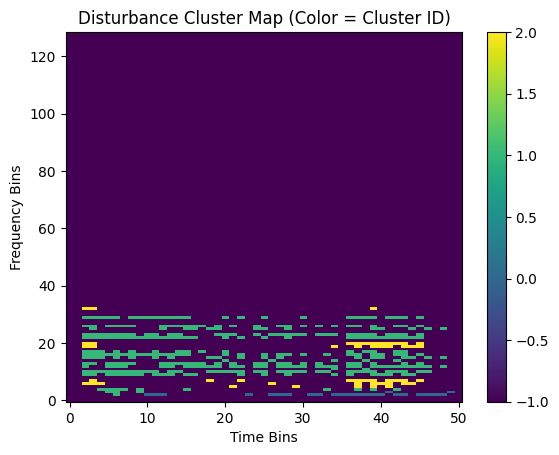

In [13]:
import numpy as np
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
from scipy.ndimage import grey_dilation
import warnings
from scipy import signal
import matplotlib.pyplot as plt

# Note: You must have numpy, scipy, sklearn, hdbscan installed
# pip install numpy scipy scikit-learn hdbscan

## 1. Core Vector & Frame Utilities

def sph_to_cart(theta_deg, phi_deg, mag=1.0):
    """Converts spherical coordinates (degrees) to Cartesian."""
    th = np.deg2rad(theta_deg)
    ph = np.deg2rad(phi_deg)
    return np.array([
        mag * np.sin(th) * np.cos(ph),
        mag * np.sin(th) * np.sin(ph),
        mag * np.cos(th)
    ], float)

def hat(v):
    """Returns the unit vector in the direction of v."""
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0:
        return np.zeros_like(v)
    return v / n

def make_skew_frame(dirs):
    """
    Build 3x3 skewed frame:
    first len(dirs) columns are exactly the given unit directions,
    remaining column(s) just complete a basis.
    """
    dirs = [hat(v) for v in dirs]
    m = len(dirs)

    if m == 0:
        return np.eye(3)

    if m == 1:
        v1 = dirs[0]
        cand = np.array([1.0, 0.0, 0.0]) if abs(v1[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
        u2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, u2))
        return np.column_stack([v1, u2, u3])

    if m == 2:
        v1, v2 = dirs
        if np.linalg.norm(np.cross(v1, v2)) < 1e-6:
            cand = np.array([1.0, 0.0, 0.0]) if abs(v1[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
            v2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, v2))
        return np.column_stack([v1, v2, u3])

    v1, v2, v3 = dirs[:3]
    return np.column_stack([v1, v2, v3])

## 2. Legacy DAFgrad Cleaning (kept for reference / comparison)

def dafgrad_clean(B, h1_dirs, h2_dirs, k_gain):
    """
    Dual-sensor DAFgrad in skewed frames.
    Used originally. Kept here in case you want to compare.
    """
    B = np.asarray(B, dtype=B.dtype)
    if B.shape[0] != 2 or B.shape[1] != 3:
        raise ValueError("B must have shape (2, 3, N)")

    h1_dirs = np.asarray(h1_dirs, float)
    h2_dirs = np.asarray(h2_dirs, float)
    k_gain = np.asarray(k_gain, float)

    if h1_dirs.ndim == 1:
        h1_dirs = h1_dirs[np.newaxis, :]
    if h2_dirs.ndim == 1:
        h2_dirs = h2_dirs[np.newaxis, :]
    if k_gain.ndim == 0:
        k_gain = k_gain[np.newaxis]

    if h1_dirs.shape != h2_dirs.shape:
        raise ValueError("h1_dirs and h2_dirs must have same shape")

    m = h1_dirs.shape[0]
    if m == 0:
        return B
    if k_gain.shape[0] != m:
        raise ValueError(f"k_gain length ({k_gain.shape[0]}) must match number of sources ({m})")

    h1 = np.array([hat(v) for v in h1_dirs])
    h2 = np.array([hat(v) for v in h2_dirs])

    H1 = h1
    H2 = k_gain[:, np.newaxis] * h2

    HDelta = H1 - H2
    hD = np.array([hat(v) for v in HDelta])

    denom = np.linalg.norm(HDelta, axis=1)
    if np.any(denom < 1e-12):
        warnings.warn("Degenerate H1 - H2 for some source. Skipping cleaning for this bin.")
        return B

    alpha1 = np.linalg.norm(H1, axis=1) / denom
    alpha2 = np.linalg.norm(H2, axis=1) / denom

    T1_inv = make_skew_frame(list(h1))
    T2_inv = make_skew_frame(list(h2))
    TD_inv = make_skew_frame(list(hD))

    try:
        T1 = np.linalg.inv(T1_inv)
        T2 = np.linalg.inv(T2_inv)
        TD = np.linalg.inv(TD_inv)
    except np.linalg.LinAlgError:
        warnings.warn("Singular skew frame. Skipping cleaning for this bin.")
        return B

    B1 = B[0].T
    B2 = B[1].T
    BD = B1 - B2

    B1_p = (T1 @ B1.T).T
    B2_p = (T2 @ B2.T).T
    BD_p = (TD @ BD.T).T

    B1_p_clean = B1_p.copy()
    B2_p_clean = B2_p.copy()

    m_capped = min(m, 3)
    for k in range(m_capped):
        B1_p_clean[:, k] -= alpha1[k] * BD_p[:, k]
        B2_p_clean[:, k] -= alpha2[k] * BD_p[:, k]

    B1_c = (T1_inv @ B1_p_clean.T).T
    B2_c = (T2_inv @ B2_p_clean.T).T

    B_clean = np.empty_like(B)
    B_clean[0] = B1_c.T
    B_clean[1] = B2_c.T
    return B_clean

## 3. SSP Identification

def is_SSP(Sf, similarity=0.98):
    """Identifies Single Source Points (SSPs)."""
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    A = np.real(X)
    B = np.imag(X)
    dot = np.sum(A * B, axis=0)
    normA = np.linalg.norm(A, axis=0)
    normB = np.linalg.norm(B, axis=0)
    norm_prod = normA * normB
    cos_sim = np.divide(dot, norm_prod, out=np.zeros_like(dot, dtype=float), where=norm_prod != 0)
    return np.abs(cos_sim) >= similarity

def magnitude_filter(Sf, percentile):
    """Magnitude filter."""
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    m = np.linalg.norm(X, axis=0)
    threshold = np.percentile(m, percentile)
    return m >= threshold

def ambient_filter(Sf, similarity=0.98):
    """Ambient noise filter."""
    n_sensors, n_axis, F, T = Sf.shape
    mags = np.linalg.norm(Sf, axis=1)
    ones = np.ones_like(mags)
    dot = np.sum(mags * ones, axis=0)
    normA = np.linalg.norm(mags, axis=0)
    normB = np.linalg.norm(ones, axis=0)
    norm_prod = normA * normB
    cos_sim = np.divide(dot, norm_prod, out=np.zeros_like(dot, dtype=float), where=norm_prod != 0)
    return cos_sim >= similarity

## 4. Disturbance Subspace Estimation (Clustering)

def remove_global_phase_two_sensor(v1, v2):
    """Remove a single global phase from two vectors for clustering."""
    stacked = np.concatenate([v1, v2])
    idx = np.argmax(np.abs(stacked))
    ref_val = stacked[idx]
    if np.abs(ref_val) == 0:
        return v1, v2
    phi = np.angle(ref_val)
    factor = np.exp(-1j * phi)
    return v1 * factor, v2 * factor

def cluster_gain_and_dir_all(SSP_data, min_cluster_size=10):
    """
    Estimate disturbance source directions and gains for all non-noise clusters found by HDBSCAN.

    SSP_data : (2, 3, n_bins), complex STFT values at SSP bins.
    """
    B1 = SSP_data[0].T
    B2 = SSP_data[1].T

    dirs1 = []
    dirs2 = []
    gains = []
    valid_indices = []

    for i, (v1, v2) in enumerate(zip(B1, B2)):
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 < 1e-12 or n2 < 1e-12:
            continue

        v1p, v2p = remove_global_phase_two_sensor(v1, v2)
        a1 = np.real(v1p)
        a2 = np.real(v2p)

        if np.linalg.norm(a1) < 1e-12 or np.linalg.norm(a2) < 1e-12:
            continue

        h1 = hat(a1)
        h2 = hat(a2)

        if h1[2] < 0:
            h1 = -h1
            h2 = -h2

        g = n2 / n1
        if not np.isfinite(g):
            continue

        dirs1.append(h1)
        dirs2.append(h2)
        gains.append(g)
        valid_indices.append(i)

    if not dirs1:
        raise ValueError("No valid SSP-derived features found for clustering.")

    dirs1 = np.asarray(dirs1)
    dirs2 = np.asarray(dirs2)
    gains = np.asarray(gains)
    valid_indices = np.asarray(valid_indices)

    feats = np.column_stack([dirs1, dirs2, np.log(gains)])
    X = StandardScaler().fit_transform(feats)

    clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
    labels_valid = clusterer.fit_predict(X)

    ssp_labels = np.full(B1.shape[0], -1, dtype=int)
    ssp_labels[valid_indices[labels_valid >= 0]] = labels_valid[labels_valid >= 0]

    unique_labels = [lab for lab in np.unique(labels_valid) if lab >= 0]
    if not unique_labels:
        raise ValueError("HDBSCAN found no clusters.")

    max_label = np.max(unique_labels)
    disturbance_params = [None] * (max_label + 1)

    print(f"HDBSCAN found {len(unique_labels)} clusters.")

    for lab in unique_labels:
        idx = (labels_valid == lab)
        if not np.any(idx):
            continue

        h1_mean = hat(dirs1[idx].mean(axis=0))
        h2_mean = hat(dirs2[idx].mean(axis=0))
        g_med = np.median(gains[idx])

        if h1_mean[2] < 0:
            h1_mean = -h1_mean
            h2_mean = -h2_mean

        disturbance_params[lab] = {'h1': h1_mean, 'h2': h2_mean, 'kg': g_med}

    return disturbance_params, ssp_labels

## 5. Subspace Pursuit Utilities

def subspace_pursuit(y, D, sparsity, max_iter=10, tol=1e-6):
    """
    Classic Subspace Pursuit for a single vector.

    y : (3,) complex
    D : (3, m) real or complex dictionary, columns are atoms
    sparsity : target support size (<= 3 here)
    """
    m = D.shape[1]
    L = min(sparsity, m)
    if L <= 0 or np.linalg.norm(y) < 1e-12:
        return np.zeros(m, dtype=complex)

    # Initial support
    Dt_y = D.conj().T @ y
    support = np.argsort(np.abs(Dt_y))[-L:]

    x = np.zeros(m, dtype=complex)
    best_r_norm = None

    for _ in range(max_iter):
        # LS on current support
        D_S = D[:, support]
        x_S, *_ = np.linalg.lstsq(D_S, y, rcond=None)
        x = np.zeros(m, dtype=complex)
        x[support] = x_S

        r = y - D @ x
        r_norm = np.linalg.norm(r)

        # Candidate indices from residual
        Dt_r = D.conj().T @ r
        cand = np.argsort(np.abs(Dt_r))[-L:]

        trial_support = np.unique(np.concatenate([support, cand]))
        D_trial = D[:, trial_support]
        x_trial, *_ = np.linalg.lstsq(D_trial, y, rcond=None)

        # Keep top-L from trial_support
        idx_sorted = np.argsort(np.abs(x_trial))[-L:]
        support_new = trial_support[idx_sorted]

        D_S_new = D[:, support_new]
        x_S_new, *_ = np.linalg.lstsq(D_S_new, y, rcond=None)

        x_new = np.zeros(m, dtype=complex)
        x_new[support_new] = x_S_new

        r_new = y - D @ x_new
        r_new_norm = np.linalg.norm(r_new)

        if best_r_norm is None or r_new_norm < best_r_norm - tol:
            best_r_norm = r_new_norm
            support = support_new
            x = x_new
            if r_new_norm < tol:
                break
        else:
            break

    return x

def sp_clean_frequency_channel(Sf_slice, H1, H2_scaled, sparsity=3, max_iter=8, tol=1e-6):
    """
    Apply Subspace Pursuit for one frequency across all time bins.

    Sf_slice : (2, 3, T)
    H1 : (m, 3) unit directions at sensor 1
    H2_scaled : (m, 3) directions at sensor 2 already scaled by kg
    """
    B1 = Sf_slice[0].copy()  # (3, T)
    B2 = Sf_slice[1].copy()  # (3, T)
    T_bins = B1.shape[1]

    m = H1.shape[0]
    if m == 0:
        return Sf_slice

    L = min(sparsity, m, 3)

    # Dictionary atoms for BD = B1 - B2
    # For true model: BD = sum a_k (h1_k - kg_k h2_k)
    D = (H1 - H2_scaled).T  # (3, m)

    B1_c = B1.copy()
    B2_c = B2.copy()

    for t in range(T_bins):
        y = B1[:, t] - B2[:, t]
        if np.linalg.norm(y) < 1e-9:
            continue

        x_hat = subspace_pursuit(y, D, sparsity=L, max_iter=max_iter, tol=tol)
        if x_hat is None:
            continue

        # Remove estimated disturbance from each sensor
        contrib1 = H1.T @ x_hat
        contrib2 = H2_scaled.T @ x_hat

        B1_c[:, t] = B1[:, t] - contrib1
        B2_c[:, t] = B2[:, t] - contrib2

    Sf_clean_slice = np.empty_like(Sf_slice)
    Sf_clean_slice[0] = B1_c
    Sf_clean_slice[1] = B2_c
    return Sf_clean_slice

## 6. Per-Channel Subspace Pursuit Pipeline

def clean_tf_data_per_channel(Sf,
                              ssp_similarity=0.95,
                              mag_percentile=90.0,
                              ambient_similarity=0.8,
                              min_cluster_size=20,
                              dilation_size=(3, 3),
                              sp_sparsity=3,
                              sp_max_iter=8):
    """
    Full pipeline to clean time-frequency data on a PER-CHANNEL basis
    using Subspace Pursuit over disturbance atoms.

    Sf : (2, 3, F, T) complex STFT data
    """
    print("Starting PER-CHANNEL T-F Subspace Pursuit cleaning pipeline...")
    n_sensors, n_axis, F, T = Sf.shape
    if n_sensors != 2 or n_axis != 3:
        raise ValueError("Input Sf must have shape (2, 3, F, T)")

    # 1. Identify SSPs
    print("Finding SSPs...")
    SSP_mask = is_SSP(Sf, similarity=ssp_similarity)
    MAG_mask = magnitude_filter(Sf, percentile=mag_percentile)
    ambient_mask = ambient_filter(Sf, similarity=ambient_similarity)
    mask = SSP_mask & MAG_mask & (~ambient_mask)

    if not np.any(mask):
        raise ValueError("No SSP bins found. Try relaxing filter thresholds.")
    print(f"Found {np.sum(mask)} SSP bins.")

    SSP_data = Sf[:, :, mask]

    # 2. Estimate disturbance atoms via clustering
    print("Clustering SSPs to find disturbance sources...")
    try:
        disturbance_params, ssp_labels = cluster_gain_and_dir_all(
            SSP_data,
            min_cluster_size=min_cluster_size
        )
    except ValueError as e:
        print(f"Clustering failed: {e}")
        print("Returning original (uncleaned) data.")
        return Sf, None

    # 3. Build T-F disturbance map
    print("Building T-F disturbance map...")
    disturbance_map = np.full((F, T), -1, dtype=int)
    disturbance_map[mask] = ssp_labels

    # 4. Dilate to propagate labels
    print("Propagating cluster labels to neighboring bins...")
    structure = np.ones(dilation_size)
    dilated_map = grey_dilation(disturbance_map, footprint=structure)

    # 5. Active sets per frequency
    per_freq_clusters = []
    for f in range(F):
        active_ids_in_row = set(dilated_map[f, :]) - {-1}
        per_freq_clusters.append(active_ids_in_row)

    active_freqs = sum(1 for s in per_freq_clusters if s)
    print(f"Found active disturbers in {active_freqs} of {F} frequency channels.")

    # 6. Apply Subspace Pursuit per channel
    print("Applying Subspace Pursuit per frequency channel...")
    Sf_clean = Sf.copy()

    for f in range(F):
        active_ids = per_freq_clusters[f]
        if not active_ids:
            continue

        # Assemble parameters for this frequency's candidate atoms
        params = [disturbance_params[cid]
                  for cid in active_ids
                  if cid < len(disturbance_params) and disturbance_params[cid] is not None]

        if not params:
            continue

        h1_active = np.vstack([p['h1'] for p in params])
        h2_active = np.vstack([p['h2'] for p in params])
        kg_active = np.array([p['kg'] for p in params])

        H1 = h1_active
        H2_scaled = kg_active[:, np.newaxis] * h2_active

        Sf_slice = Sf[:, :, f, :]
        Sf_clean_slice = sp_clean_frequency_channel(
            Sf_slice,
            H1,
            H2_scaled,
            sparsity=sp_sparsity,
            max_iter=sp_max_iter,
            tol=1e-6
        )
        Sf_clean[:, :, f, :] = Sf_clean_slice

    print("Per-channel Subspace Pursuit cleaning complete.")
    return Sf_clean, dilated_map

## 7. Example Usage and RMSE

if __name__ == "__main__":
    fs = 40.0
    Tsec = 120.0
    seed = 1

    rng = np.random.default_rng(seed)
    t = np.arange(0, Tsec, 1.0 / fs)
    N = t.size

    # Ambient
    B0 = np.column_stack([
        0.4 * np.sin(2 * np.pi * 0.04 * t) + 0.6 * np.cos(2 * np.pi * 0.1 * t),
        0.4 * np.cos(2 * np.pi * 0.03 * t + 0.6) + 0.6 * np.sin(2 * np.pi * 0.1 * t),
        0.3 * np.sin(2 * np.pi * 0.025 * t + 1.1) + 0.7 * np.cos(2 * np.pi * 0.05 * t),
    ]) + np.array([3, -2, 1])[None, :]

    # Disturbances
    S_A = np.sin(2 * np.pi * (0.12 * t + 0.001 * t**2))
    S_B = 0.6 * np.sin(2 * np.pi * (0.26 * t - 0.0008 * t**2) + 0.4) + signal.square(2 * np.pi * 1 * t) * 0.4
    S_C = signal.sawtooth(2 * np.pi * 0.5 * t)

    H1A = sph_to_cart(50, 240, 20)
    H2A = sph_to_cart(52, 132, 1)
    H1B = sph_to_cart(180, 50, 10)
    H2B = sph_to_cart(44, 100, 1)
    H1C = sph_to_cart(120, 300, 15)
    H2C = sph_to_cart(130, -210, 0.5)

    h1_true = np.array([hat(H1A), hat(H1B), hat(H1C)])
    h2_true = np.array([hat(H2A), hat(H2B), hat(H2C)])
    k_true = np.array([
        np.linalg.norm(H2A) / np.linalg.norm(H1A),
        np.linalg.norm(H2B) / np.linalg.norm(H1B),
        np.linalg.norm(H2C) / np.linalg.norm(H1C),
    ])

    b1 = np.outer(S_A, H1A) + np.outer(S_B, H1B) + np.outer(S_C, H1C)
    b2 = np.outer(S_A, H2A) + np.outer(S_B, H2B) + np.outer(S_C, H2C)

    B = np.zeros((2, 3, N))
    B[0] = (B0 + b1).T
    B[1] = (B0 + b2).T

    B_true = np.zeros_like(B)
    B_true[0] = B0.T
    B_true[1] = B0.T

    # STFT
    window = hann(256)
    SFT = ShortTimeFFT(win=window, hop=100, fs=fs)

    n_sensors, n_axis, N_samples = B.shape
    F_bins = SFT.mfft // 2 + 1

    B_flat = B.reshape(n_sensors * n_axis, N_samples)
    Sf_flat = SFT.stft(B_flat, axis=1)
    n_times = Sf_flat.shape[-1]
    Sf = Sf_flat.reshape(n_sensors, n_axis, F_bins, n_times)

    print(f"Created noisy T-F data with shape: {Sf.shape}")

    try:
        Sf_clean, dmap = clean_tf_data_per_channel(
            Sf,
            ssp_similarity=0.9,
            mag_percentile=85.0,
            ambient_similarity=0.8,
            min_cluster_size=10,
            dilation_size=(1, 1),
            sp_sparsity=3,
            sp_max_iter=8
        )

        if dmap is not None:
            print("\n--- Pipeline Succeeded ---")
            print(f"Clean T-F data shape: {Sf_clean.shape}")

            # Invert STFT
            Sf_clean_flat = Sf_clean.reshape(n_sensors * n_axis, F_bins, n_times)
            B_clean_flat = SFT.istft(Sf_clean_flat)
            n_samples_out = B_clean_flat.shape[-1]
            B_clean = B_clean_flat.reshape(n_sensors, n_axis, n_samples_out)

            if B_clean.shape[2] > N_samples:
                B_clean = B_clean[:, :, :N_samples]

            print(f"Cleaned time-domain signal shape: {B_clean.shape}")

            # RMSE
            if B_clean.shape[2] != B_true.shape[2]:
                print("Warning: length mismatch, trimming for RMSE.")
                B_true_trimmed = B_true[:, :, :B_clean.shape[2]]
                B_noisy_trimmed = B[:, :, :B_clean.shape[2]]
            else:
                B_true_trimmed = B_true
                B_noisy_trimmed = B

            err_noisy = B_noisy_trimmed - B_true_trimmed
            rmse_noisy = np.sqrt(np.mean(err_noisy**2))

            err_clean = B_clean - B_true_trimmed
            rmse_clean = np.sqrt(np.mean(err_clean**2))

            print("\n--- RMSE Comparison ---")
            print(f"RMSE (Original vs True): {rmse_noisy:.4f}")
            print(f"RMSE (Cleaned vs True): {rmse_clean:.4f}")
            if rmse_clean < rmse_noisy:
                print("Result: Subspace Pursuit cleaning reduced the error.")
            else:
                print("Warning: Cleaning did not reduce the error.")

            plt.figure()
            plt.imshow(dmap, aspect='auto', origin='lower', interpolation='none')
            plt.title("Disturbance Cluster Map (Color = Cluster ID)")
            plt.xlabel("Time Bins")
            plt.ylabel("Frequency Bins")
            plt.colorbar()
            plt.show()

    except ValueError as e:
        print("\n--- Pipeline Failed ---")
        print(f"Error: {e}")
